In [126]:
### THIS CELL SETS UP THE GOOGLE COLAB ENVIRONMENT. 
### IF RUNNING THIS NOTEBOOK LOCALLY, IT MAY BE SAFELY DELETED.

#@markdown Install the software by pressing the _Play_ button on the left.

try:
    import google.colab
    RUNNING_IN_COLAB = True
except ImportError:
    RUNNING_IN_COLAB = False
except Exception as e: 
    err = "Could not figure out if runnning in a colab notebook\n"
    raise Exception(err) from e

if RUNNING_IN_COLAB:
    !pip install dataprob


## API demonstration

This notebook demonstrates various features of the dataprob API. 


In [127]:
%matplotlib inline
import numpy as np
import pandas as pd
import dataprob

### Define model

This is the model we will use to describe our experimental data. dataprob will find parameters to the model consistent with our data. 

+ The function must take at least one float argument somewhere in its 
  definition. These arguments are the parameters that will be estimated. 

+ The function must return a numpy array the same length as the numpy array of 
  observations.


The cell below defines a linear model ($y = mx + b$)


In [128]:
def linear_model(m=0,b=0,x=None): 
    return m*x + b

### Generate some noisy data

This is a step that only exists for the example. For real analyses, `y_obs` and `y_std` would hold your experimental data. (See the [documentation](https://datatprob.readthedocs.io/)  for more information). 

In [135]:
# Observed data will have a slope of -5 and an intercept of 100
gen_params = {"m":-5,"b":10}

# Set up to collect 20 data points between -5 and 5, with an uncertainty on each 
# observation of 1
num_points = 20
x = np.linspace(0,10,num_points)
err = np.random.normal(0,1,num_points)

# Generate y_obs and y_std. Make the estimated uncertainty larger than the
# noise to refuncertainty
y_obs = linear_model(x=x,**gen_params) + err
y_std = 1

expt_df = pd.DataFrame({"y_obs":y_obs,
                        "y_std":y_std})


### Run analysis

This runs the whole analysis. We pass in `x` values as non-fittable parameters to our linear model, then fit values of `m` and `b`. 

In [136]:
# we need to send `x` into our model as a non-fittable parameter holding the 
# x-values for the line. 
x = np.linspace(-5,5,num_points)
non_fit_kwargs = {"x":x}

# Generate Fitter. (Set method to "bootstrap" or "mcmc" to see the other
# analysis methods in action). 
f = dataprob.setup(some_function=linear_model,
                   method="ml",
                   non_fit_kwargs=non_fit_kwargs)

f.data_df = expt_df

# Run fit
f.fit()

### Examine fit results

This shows our estimated fit values and their associated uncertainties. 

In [137]:
# Show fit result dataframe
f.fit_df 

,name,estimate,std,low_95,high_95,guess,fixed,lower_bound,upper_bound,prior_mean,prior_std
name,,,,,,,,,,,
m,m,-5.033898,0.052099,-5.143817,-4.923979,0.0,False,-inf,inf,NaN,NaN
b,b,-14.893524,0.158114,-15.227115,-14.559933,0.0,False,-inf,inf,NaN,NaN


The next two cells plot the results in two different ways

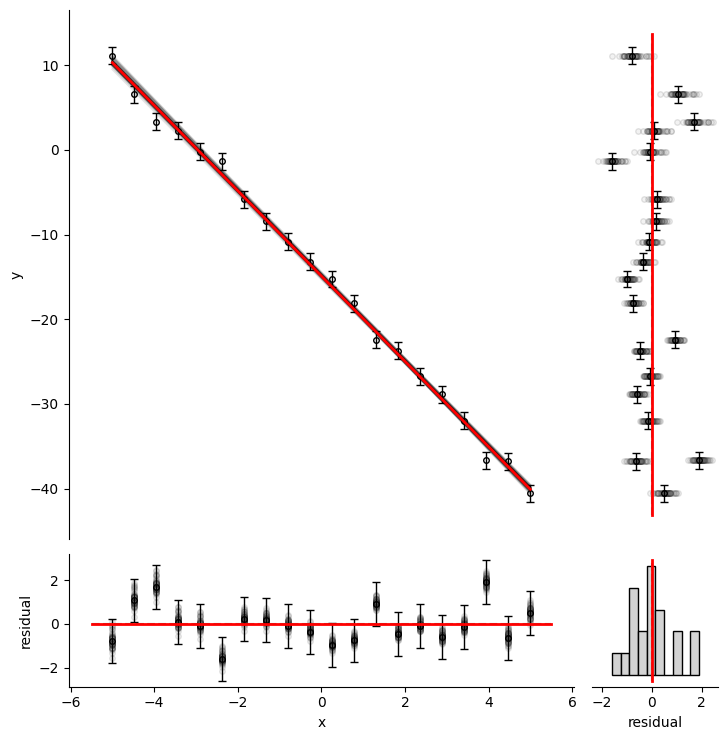

In [138]:
# Plot the summary and save as a pdf
fig = dataprob.plot_summary(f,
                            x_axis=x,
                            x_label="x",
                            y_label="y")
fig.savefig("summary-fig.pdf")

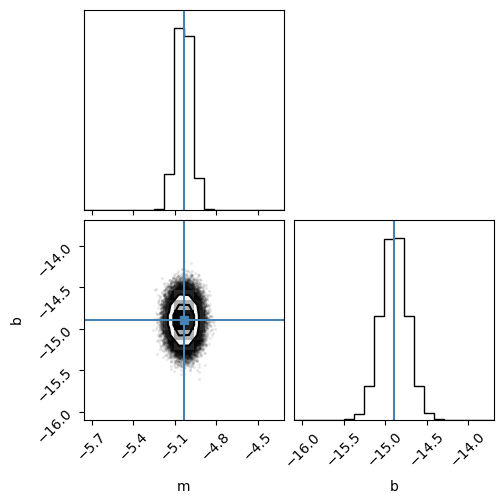

In [139]:
# Plot the corner plot and save as a pdf
fig = dataprob.plot_corner(f)
fig.savefig("corner-fig.pdf")

### Assess fit quality

The following call tests the quality of the fit. The `is_good` column should be `True` for all tests. Because these are based on p-value cutoffs, one test may fail due to chance. 

In [141]:
# Get fit quality statistics
f.fit_quality

,description,is_good,value,message
name,,,,
num_obs,number of observations,True,20.000000,
num_param,number of fit parameters,True,2.000000,There are 18 more observations than fit parame...
lnL,log likelihood,True,-25.662785,
chi2,chi^2 goodness-of-fit,True,0.626565,A p-value of 6.266e-01 for the a goodness-of-f...
reduced_chi2,reduced chi^2,True,0.856943,A reduced chi^2 value of 0.857 is consistent w...
mean0_resid,t-test for residual mean != 0,True,1.000000,A p-value of 1.000e+00 for the one-sample t-te...
durbin-watson,Durbin-Watson test for correlated residuals,True,2.032198,A Durbin-Watson test-statistic of 2.032 is con...
ljung-box,Ljung-Box test for correlated residuals,True,0.131119,A p-value of 1.311e-01 for the Ljung-Box test ...


### Modify parameter guesses and bounds

In [142]:
x = np.linspace(-5,5,num_points)
non_fit_kwargs = {"x":x}

# Generate Fitter. (Set method to "bootstrap" or "mcmc" to see the other
# analysis methods in action). 
f = dataprob.setup(some_function=linear_model,
                   method="ml",
                   non_fit_kwargs=non_fit_kwargs)
f.data_df = expt_df

f.param_df

,name,guess,fixed,lower_bound,upper_bound,prior_mean,prior_std
name,,,,,,,
m,m,0.0,False,-inf,inf,NaN,NaN
b,b,0.0,False,-inf,inf,NaN,NaN


In [143]:
f.param_df.loc["m","guess"] = 10
f.param_df.loc["b","lower_bound"] = 95
f.param_df.loc["b","guess"] = 200
f.param_df

,name,guess,fixed,lower_bound,upper_bound,prior_mean,prior_std
name,,,,,,,
m,m,10.0,False,-inf,inf,NaN,NaN
b,b,200.0,False,95.0,inf,NaN,NaN


In [144]:
f.fit()
f.fit_df

,name,estimate,std,low_95,high_95,guess,fixed,lower_bound,upper_bound,prior_mean,prior_std
name,,,,,,,,,,,
m,m,-5.033898,0.052099,-5.143817,-4.923980,10.0,False,-inf,inf,NaN,NaN
b,b,95.000000,0.158114,94.666409,95.333591,200.0,False,95.0,inf,NaN,NaN


### Run an MCMC analysis

This analyzes the same data using the same model, but instead of finding the maximum likelihood paramter estimate, it uses a Bayesian sampling approach to find the posterior distribution of the parameters. 


100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 333.37it/s]


,name,estimate,std,low_95,high_95,guess,fixed,lower_bound,upper_bound,prior_mean,prior_std
name,,,,,,,,,,,
m,m,-5.022761,0.071044,-5.175083,-4.888645,0.0,False,-inf,inf,NaN,NaN
b,b,-14.884097,0.222436,-15.313992,-14.449893,0.0,False,-inf,inf,NaN,NaN


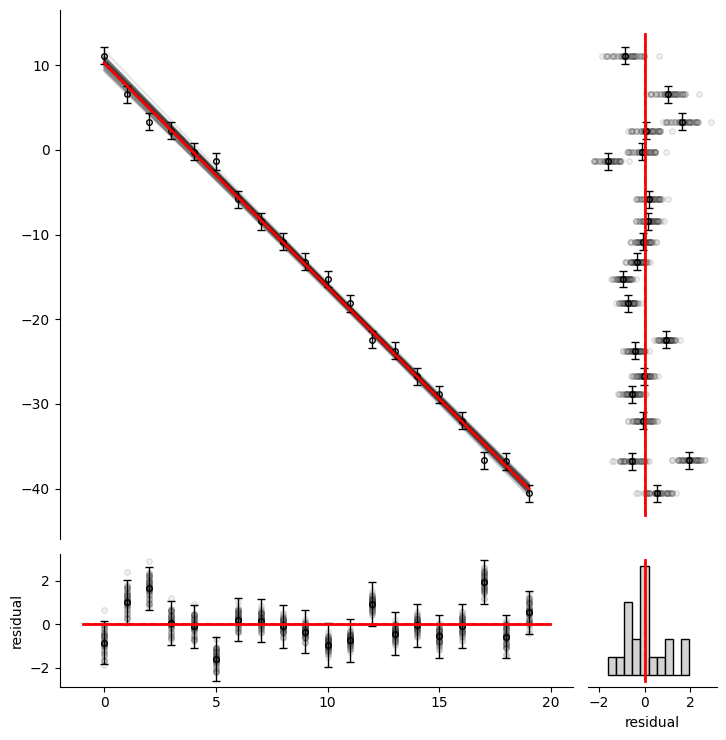

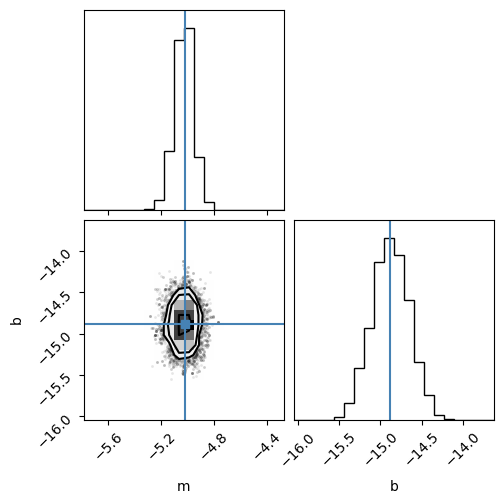

In [145]:
x = np.linspace(-5,5,num_points)
non_fit_kwargs = {"x":x}

# Select the "mcmc" method
f = dataprob.setup(some_function=linear_model,
                   method="mcmc", # <<<--- 
                   non_fit_kwargs=non_fit_kwargs)
f.data_df = expt_df

# Run fit
f.fit()

# Plot results
fig = dataprob.plot_summary(f)
fig = dataprob.plot_corner(f)
f.fit_df

### Set MCMC Priors

In [146]:
x = np.linspace(-5,5,num_points)
non_fit_kwargs = {"x":x}

# Select the "mcmc" method
f = dataprob.setup(some_function=linear_model,
                   method="mcmc", # <<<---
                   non_fit_kwargs=non_fit_kwargs)
f.data_df = expt_df
f.param_df

,name,guess,fixed,lower_bound,upper_bound,prior_mean,prior_std
name,,,,,,,
m,m,0.0,False,-inf,inf,NaN,NaN
b,b,0.0,False,-inf,inf,NaN,NaN


In [147]:
f.param_df.loc["m","prior_mean"] = -5
f.param_df.loc["m","prior_std"] = 2
f.param_df

,name,guess,fixed,lower_bound,upper_bound,prior_mean,prior_std
name,,,,,,,
m,m,0.0,False,-inf,inf,-5.0,2.0
b,b,0.0,False,-inf,inf,NaN,NaN


100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 249.57it/s]


,name,estimate,std,low_95,high_95,guess,fixed,lower_bound,upper_bound,prior_mean,prior_std
name,,,,,,,,,,,
m,m,-5.052296,0.073155,-5.177304,-4.897788,0.0,False,-inf,inf,-5.0,2.0
b,b,-14.878966,0.222312,-15.322271,-14.456982,0.0,False,-inf,inf,NaN,NaN


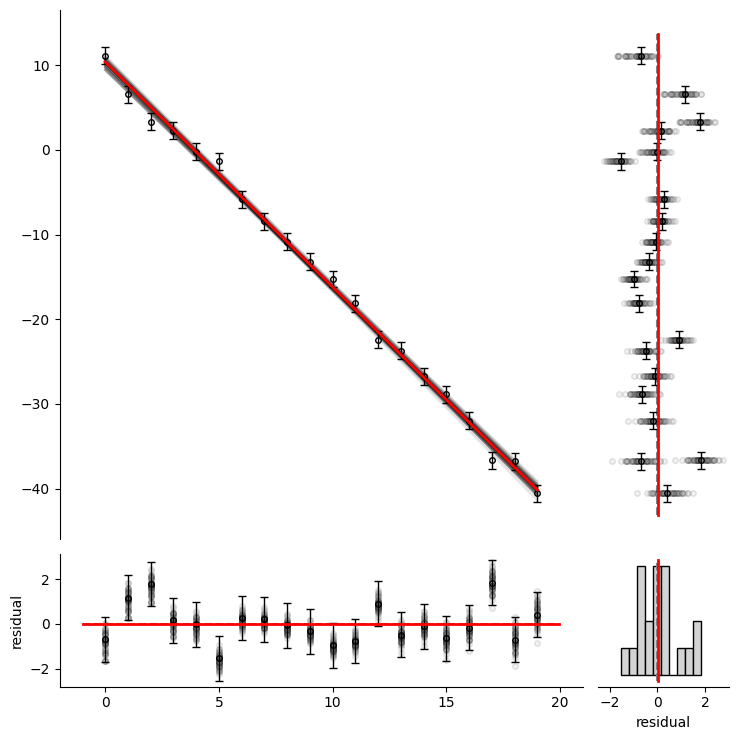

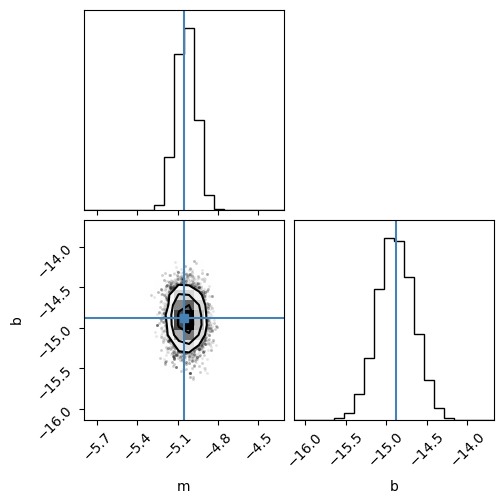

In [148]:
# Run fit
f.fit()

# Plot results
fig = dataprob.plot_summary(f)
fig = dataprob.plot_corner(f)
f.fit_df